# Predict user converting to paid in a freemium fitness app

## 1. Load libraries and data

In [78]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns 

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold, RandomizedSearchCV 
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 

In [4]:
data = pd.read_csv("C:/Users/VanDoan/OneDrive - Rightpoint/Analysis/strong-app-user-behaviors.csv")

data.head()

,user_id,session_count,avg_session_duration,pageviews_per_session,days_since_last_visit,feature_usage_rate,clicks_on_premium_content,referral_source,state,device_type,...,messages_sent_count,messages_received_count,posts_count,reactions_count,community_sessions_count,number_of_trainings_watched,number_of_trainings_finished,daily_steps,daily_workout_minutes,subscription_status
0,1,19,54.026249,5,17,0.800647,3,referral,Florida,mobile,...,12,4,0,9,2,9,2,5077,32,1
1,2,15,54.766158,1,7,0.194363,3,organic,New York,mobile,...,6,5,1,5,4,14,5,5071,21,1
2,3,12,19.629210,3,18,0.253486,2,organic,Texas,desktop,...,11,5,4,9,3,10,5,5042,33,0
3,4,20,57.280056,3,19,0.482543,1,ad,Florida,tablet,...,2,3,0,7,12,10,3,4918,40,0
4,5,18,49.216602,4,0,0.693894,3,organic,Florida,tablet,...,1,4,3,10,10,6,6,5003,30,0


## 2. Exploratory data analysis EDA

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   user_id                        10000 non-null  int64  
 1   session_count                  10000 non-null  int64  
 2   avg_session_duration           10000 non-null  float64
 3   pageviews_per_session          10000 non-null  int64  
 4   days_since_last_visit          10000 non-null  int64  
 5   feature_usage_rate             10000 non-null  float64
 6   clicks_on_premium_content      10000 non-null  int64  
 7   referral_source                10000 non-null  object 
 8   state                          10000 non-null  object 
 9   device_type                    10000 non-null  object 
 10  number_of_visits_last_week     10000 non-null  int64  
 11  number_of_visits_last_30_days  10000 non-null  int64  
 12  messages_sent_count            10000 non-null  

In [40]:
print('number of paid and free users', '\n', data['subscription_status'].value_counts())
print()
print('percentage of paid and free users', '\n', data['subscription_status'].value_counts(normalize=True))

number of paid and free users 
 subscription_status
0    6087
1    3913
Name: count, dtype: int64

percentage of paid and free users 
 subscription_status
0    0.6087
1    0.3913
Name: proportion, dtype: float64


In [6]:
data.columns

Index(['user_id', 'session_count', 'avg_session_duration',
       'pageviews_per_session', 'days_since_last_visit', 'feature_usage_rate',
       'clicks_on_premium_content', 'referral_source', 'state', 'device_type',
       'number_of_visits_last_week', 'number_of_visits_last_30_days',
       'messages_sent_count', 'messages_received_count', 'posts_count',
       'reactions_count', 'community_sessions_count',
       'number_of_trainings_watched', 'number_of_trainings_finished',
       'daily_steps', 'daily_workout_minutes', 'subscription_status'],
      dtype='object')

In [41]:
features = ['session_count', 'avg_session_duration',
       'pageviews_per_session', 'days_since_last_visit', 'feature_usage_rate',
       'clicks_on_premium_content', 
       'number_of_visits_last_week', 'number_of_visits_last_30_days',
       'messages_sent_count', 'messages_received_count', 'posts_count',
       'reactions_count', 'community_sessions_count',
       'number_of_trainings_watched', 'number_of_trainings_finished',
       'daily_steps', 'daily_workout_minutes']

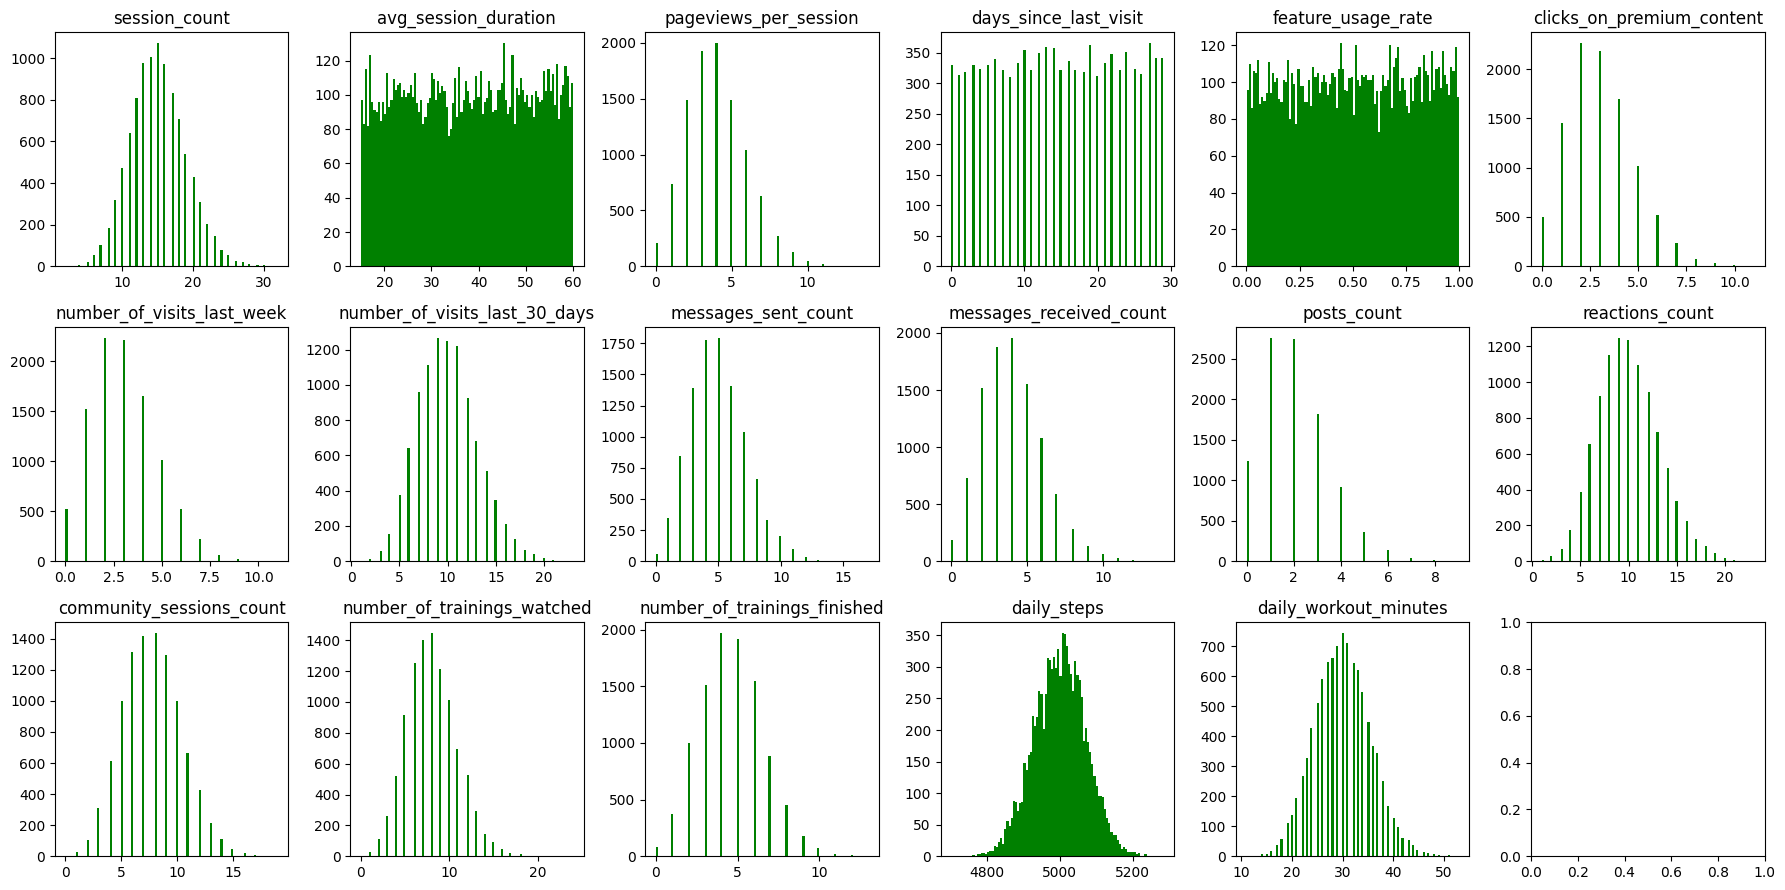

In [42]:
fig, axes = plt.subplots(3, 6, figsize=(18, 9))

for feature, ax in zip(features, axes.ravel()):
    ax.hist(data[feature], bins=100, color='green')
    ax.set_title(feature)

plt.tight_layout()

<Axes: >

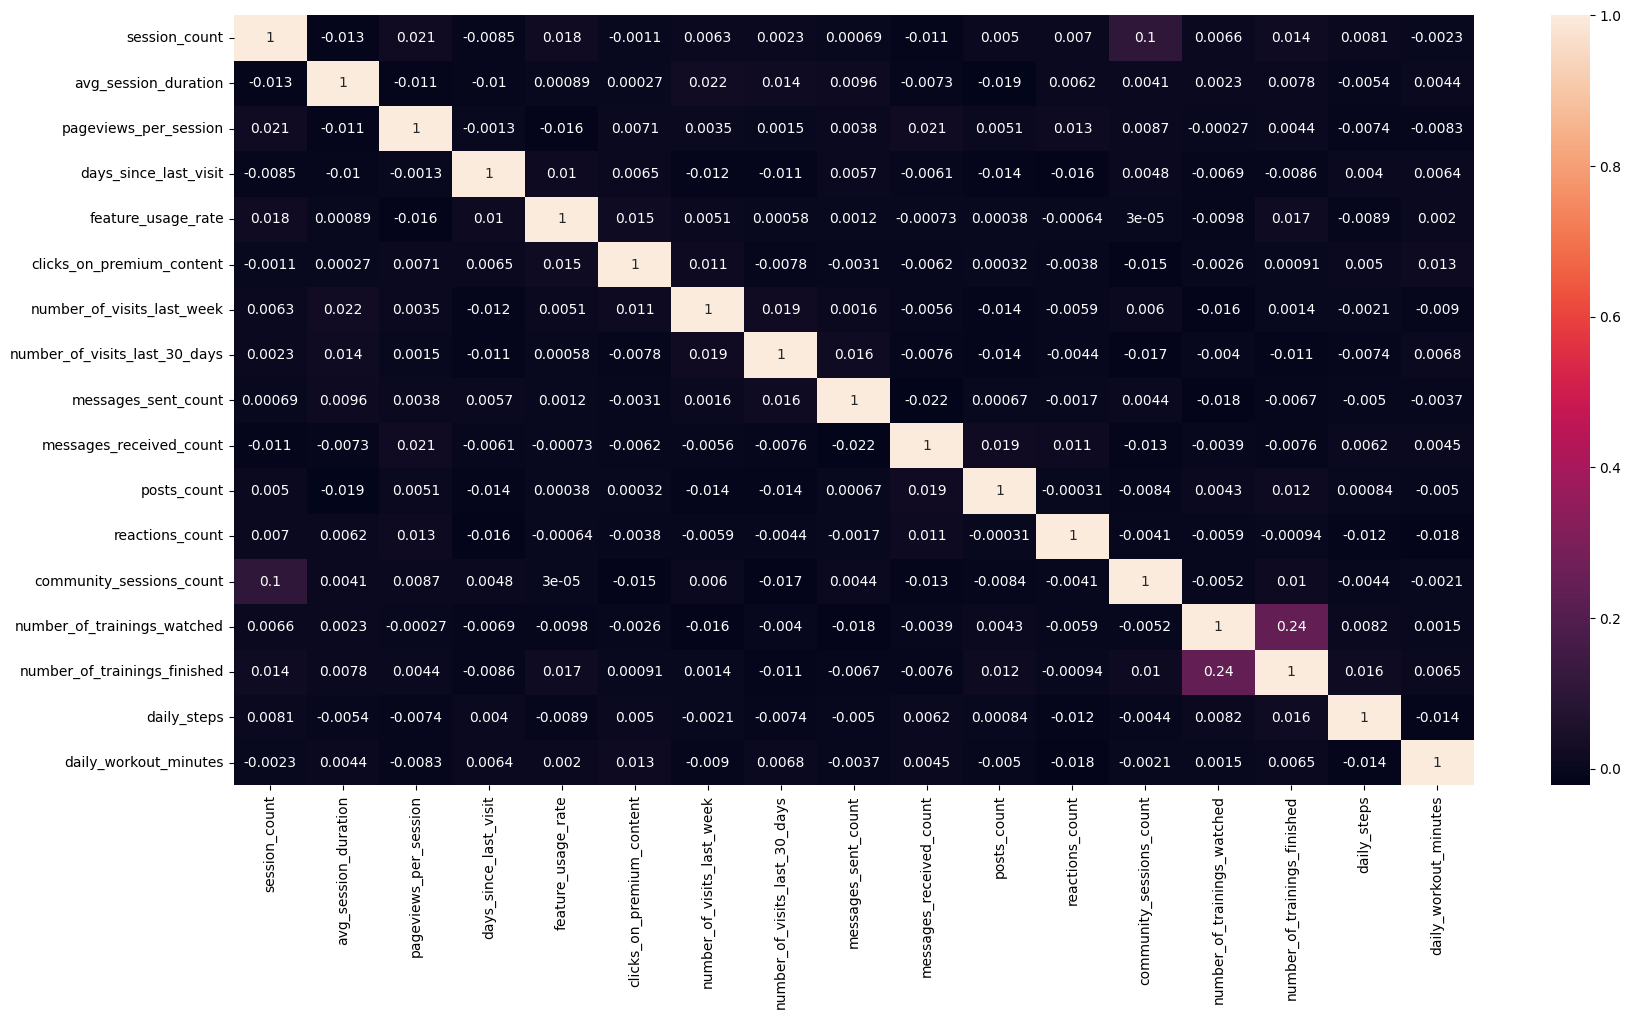

In [43]:
plt.figure(figsize=(20,10))
sns.heatmap(data[features].corr(), annot=True)

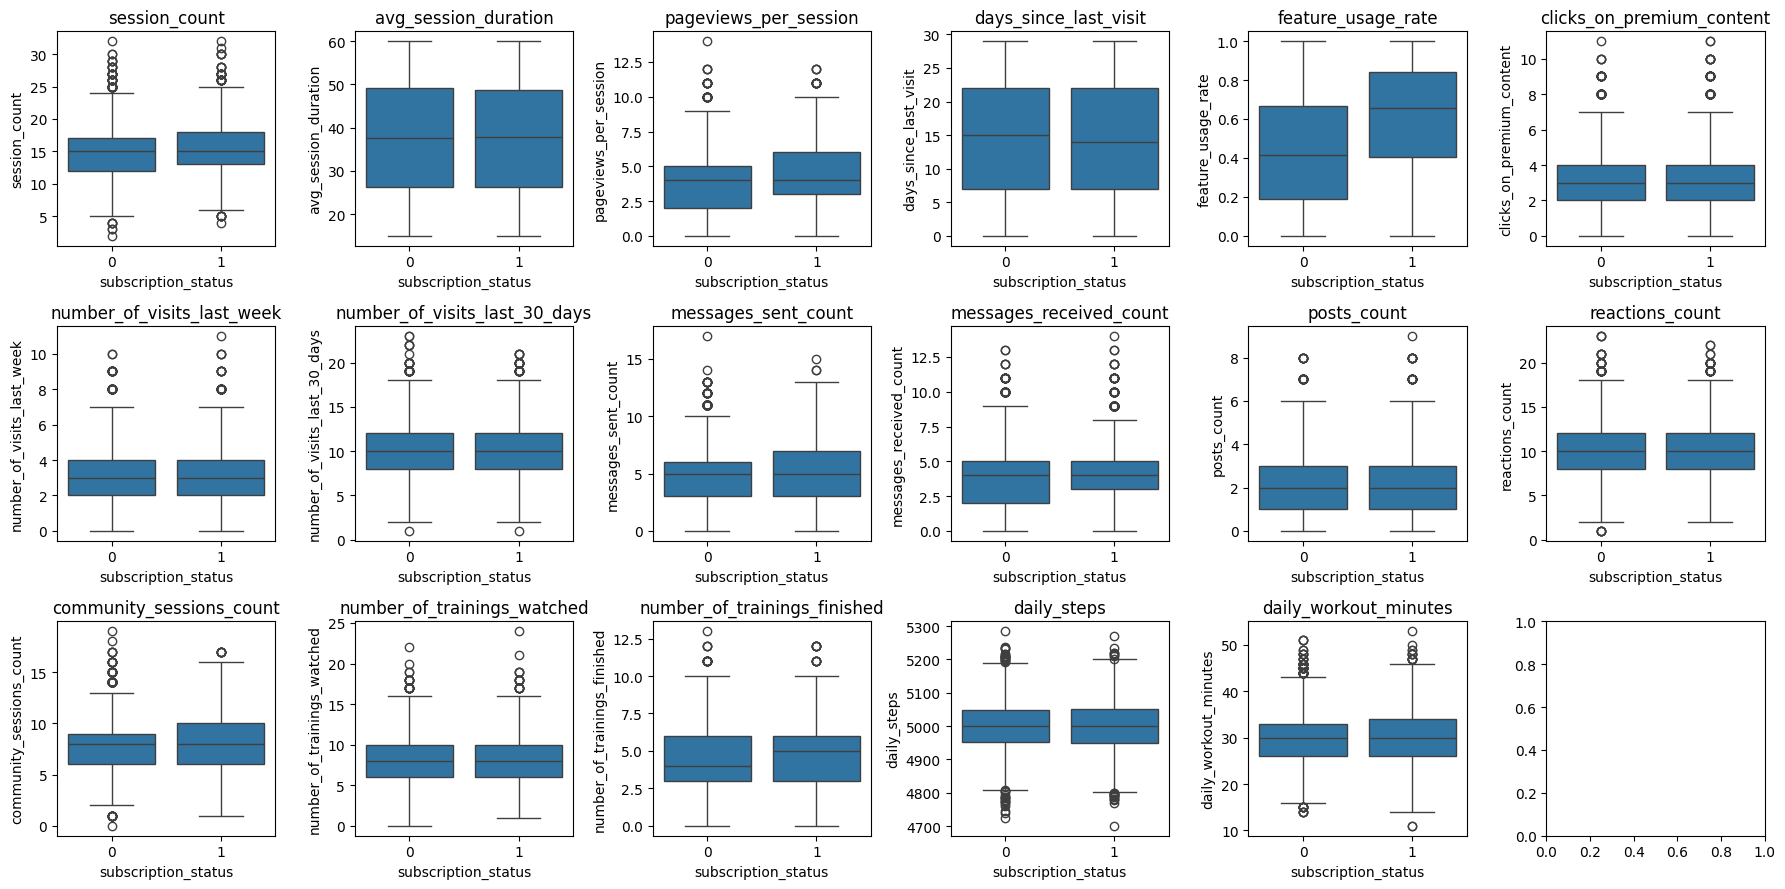

In [49]:
fig, axes = plt.subplots(3,6, figsize=(18,9))

for feature, ax in zip(features, axes.ravel()):
    sns.boxplot(x='subscription_status', y=feature, data=data, ax=ax)
    ax.set_title(feature)

plt.tight_layout()

In [50]:
cat_features = ['referral_source', 'state', 'device_type']
for feature in cat_features:
    print(data.groupby(feature)['subscription_status'].mean())
    print()

referral_source
ad          0.402319
organic     0.374421
referral    0.396471
Name: subscription_status, dtype: float64

state
California    0.391687
Florida       0.390438
Illinois      0.398230
New York      0.392177
Texas         0.383533
Name: subscription_status, dtype: float64

device_type
desktop    0.385633
mobile     0.390770
tablet     0.397482
Name: subscription_status, dtype: float64



## 3. Pre-processing

In [96]:
data.columns

Index(['user_id', 'session_count', 'avg_session_duration',
       'pageviews_per_session', 'days_since_last_visit', 'feature_usage_rate',
       'clicks_on_premium_content', 'referral_source', 'state', 'device_type',
       'number_of_visits_last_week', 'number_of_visits_last_30_days',
       'messages_sent_count', 'messages_received_count', 'posts_count',
       'reactions_count', 'community_sessions_count',
       'number_of_trainings_watched', 'number_of_trainings_finished',
       'daily_steps', 'daily_workout_minutes', 'subscription_status'],
      dtype='object')

In [101]:
X = data.drop(columns='subscription_status')
y = data['subscription_status']

X = pd.get_dummies(X, drop_first=True)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=123)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)


## 3. Model training

### 3.1 Logistic Regression

In [102]:
logclf = LogisticRegression(solver='saga', random_state=42)

logclf.fit(X_train_scaled, y_train)

y_pred_log = logclf.predict(X_test_scaled)
y_pred_prob_log = logclf.predict_proba(X_test_scaled)

# AUC score 
auc = roc_auc_score(y_test, y_pred_prob_log[:,1])
print('AUC score = ', auc) 

# Classification report
print()
print('Classification report:')
print(classification_report(y_test, y_pred_log))

AUC score =  0.7142503339766253

Classification report:
              precision    recall  f1-score   support

           0       0.70      0.82      0.76      1217
           1       0.62      0.45      0.52       783

    accuracy                           0.68      2000
   macro avg       0.66      0.64      0.64      2000
weighted avg       0.67      0.68      0.66      2000



### 3.2 Random Forest

In [103]:
rfrc = RandomForestClassifier(n_estimators=500, min_samples_leaf=0.15, class_weight='balanced', random_state=42)

rfrc.fit(X_train_scaled, y_train)

y_pred_rf = rfrc.predict(X_test_scaled)
y_pred_prob_rf = rfrc.predict_proba(X_test_scaled)

# AUC score 
auc_rf = roc_auc_score(y_test, y_pred_prob_rf[:,1])
print('AUC score = ', auc_rf)

# Classification reprot 
print()
print('Classification report:')
print(classification_report(y_test, y_pred_rf))

AUC score =  0.6902029675384165

Classification report:
              precision    recall  f1-score   support

           0       0.73      0.62      0.67      1217
           1       0.53      0.65      0.58       783

    accuracy                           0.63      2000
   macro avg       0.63      0.64      0.63      2000
weighted avg       0.65      0.63      0.64      2000



### Fine tuning

In [93]:
param_grid_rf = {
    'n_estimators': [50, 100, 200, 500],                                   
    'min_samples_leaf': [0.01, 0.05, 0.1, 0.15],
    'class_weight': ['balanced', 'balanced_subsample']                     
}

rf_cv = RandomizedSearchCV(rfrc, param_grid_rf, cv=kf, n_iter=30, verbose=1, n_jobs=-1)
rf_cv.fit(X_train_scaled, y_train)

print(rf_cv.best_params_, rf_cv.best_score_)


Fitting 5 folds for each of 30 candidates, totalling 150 fits
{'n_estimators': 500, 'min_samples_leaf': 0.01, 'class_weight': 'balanced'} 0.64025
